# OSGD - GAN Project - MNIST Fashion


## Contents
1. Setup
2. Loading The Data
3. Defining the GAN Class
4. Instantiating a GAN
5. Training and Testing

## 1. Setup

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.autograd.variable import Variable

import math 
import seaborn as sns # To plot graphs
import pandas as pd

## 2. Loading The Data

In [2]:
train_set = torchvision.datasets.FashionMNIST(        # Gets the train_set from FashionMNIST
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [3]:
# Helper function to display images
def show_images(images_arry,num_images_to_show,title):
    # Imput: images_arry, an array of tensors to display as images; num_images_to_show, integer representing num images to show
    # Output: prints images as output
    
    n = np.min([len(images_arry),num_images_to_show]) # Number of images to display
    fig, ax = plt.subplots(1,n) # Makes an array of subplot objects 
    fig.suptitle(title)
    
    for index in range(n):
        ax[index].imshow(images_arry[index].squeeze(), cmap='gray_r'); # Investigate the cmap
        ax[index].axis('off')  # clear x-axis and y-axis

In [4]:
temp_data_loader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True)
temp_dataiter = iter(temp_data_loader)
images,labels = temp_dataiter.next()

torch.Size([1, 28, 28])


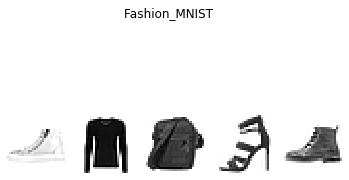

In [5]:
show_images(images,5,'Fashion_MNIST')
print(images[0].size())

## 3. Defining the GAN Class

In [6]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self,ModuleList):
        # Input: a torch.nn.ModuleList object, specifying nn layers
        # Output: Instanciates a nn object with the correct layers and activiation functions
        
        super(NeuralNetwork,self).__init__()
        self.layers = ModuleList # Sets network layers
        
    def forward(self,x):
        # Input: a tensor x, with size that agrees with the network
        # Output: a tensor, the network evaluated on x
        
        for l in self.layers:
            x = l(x)
        return x

In [7]:
def ones_target(n):
    # Input: An integer n
    # Output: Tensor of 1's size nx1
    
    return Variable(torch.ones(n,1))
    
def zeros_target(n):
    # Input: An integer n
    # Output: Tensor of 0's size nx1
    
    return Variable(torch.zeros(n,1))

In [8]:
class GAN():
    def __init__(self,d_ModuleList,g_ModuleList):
        # Input: d_ModuleList,g_ModuleList are torch.nn.ModuleLists
        # Output: Instance of GAN class 
        
        # Instantiate the discriminator & generator
        self.discriminator = NeuralNetwork(d_ModuleList)
        self.generator = NeuralNetwork(g_ModuleList)
        
        self.dim = d_ModuleList[0][0].in_features # Number of inputs into discriminator = dimention of data
        self.latent_dim = g_ModuleList[0][0].in_features # Number of inputs into generator = dimention of latent space
    
    def update_discriminator(self,real_data,generated_data):
        # Input: real_data (minibatch from real data set) ,generated_data (minibatch made by generator)
        # Output: discriminator's loss and mean predictions for real and generated data
        
        # Initial setup/clearing of gradients
        self.d_optimiser.zero_grad()
        loss = nn.BCELoss()
        N,M = real_data.size(0),generated_data.size(0)
        
        # Apply discriminator to data entered (in order real then fake)
        x = self.discriminator(torch.cat([real_data,generated_data]))
        
        # Create target labels (in order real then fake)
        y = torch.cat([ones_target(N),zeros_target(M)])
        
        # Calculate loss and backprop
        error = loss(x,y)
        error.backward()
        
        # Update discriminator network
        self.d_optimiser.step()
        
        # Return error and mean predictions
        return error.detach().numpy(), torch.mean(x[:N].detach()).numpy(),torch.mean(x[-M:].detach()).numpy()
        
    def update_generator(self,generated_data):
        # Input: generated_data (minibatch made by generator)
        # Output: generators' loss
        
        # Initial setup/clearing of gradients
        self.g_optimiser.zero_grad()
        loss = nn.BCELoss()
        M = generated_data.size(0)
        
        # Apply discriminator to data entered
        x = self.discriminator(generated_data)
        
        # Create target labels
        y = ones_target(M) # Want target to be 1's, opposite of disciminator's aim
        
        # Calculate loss and backprop
        error = loss(x,y)
        error.backward()
        
        # Update generator network
        self.g_optimiser.step()
        
        # Return error
        return error.detach().numpy() 
    
    def batch_train(self,data_batch,d_learning_rate,g_learning_rate):
        # Input: data_batch (in a tensor size 1 by n),d_learning_rate/g_learning_rate, learning rates for each nn
        # Output: returns progress info, updates discriminator and generator networks
        
        # Sets optimisers
        self.d_optimiser = optim.Adam(self.discriminator.parameters(), d_learning_rate)
        self.g_optimiser = optim.Adam(self.generator.parameters(), g_learning_rate)
        
        k = 1 # Number of steps to apply to the discriminator, In original paper this variable is assigned to 1
        n = data_batch.size(0) # Number of data items in  batch
        

        for i in range(k):
            # Get batch of real data
            real_data = data_batch.view(-1,self.dim) # Shapes data into a collumn vector, if not already in correct view
                
            # Get batch of fake data from generator
            generated_data = self.generator(self.noise(n).detach()) # Same size as real_data, detatch so generator gradient not affected
            
            # Optimise discriminator
            d_error,avg_real_pred,avg_fake_pred = self.update_discriminator(real_data,generated_data)
            
            
        # Optimise generator, with new batch of generated data
        generated_data = self.generator(self.noise(n)) # Need new data here as discriminator has been trained on the 'old' generated_data
        g_error = self.update_generator(generated_data)
        
        return g_error,d_error,avg_real_pred,avg_fake_pred
            
    def noise(self,n):
    # Input: An integer n, the number of samples to make
    # Output: A tensor of size nxdims of random values

        return Variable(torch.randn(n,self.latent_dim))
    
    def generate(self,n):
        # Input: n (number of values to geneerate)
        # Output: n generated data items from the generator
        
        return self.generator(self.noise(n)).detach().numpy()

## 4. Instantiating a GAN

In [9]:
fashion_GAN = GAN(nn.ModuleList([
                    nn.Sequential( 
                        nn.Linear(784, 1024),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
                    ),
                    nn.Sequential(
                        nn.Linear(1024, 512),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3)
                    ),
                    nn.Sequential(
                        torch.nn.Linear(512, 1),
                        torch.nn.Sigmoid() # Sigmoid activation layer, so value out is in (0,1) representing a probability
                    )]),
                nn.ModuleList([
                    nn.Sequential(
                        nn.Linear(512,1024),
                        nn.LeakyReLU(0.1)
                    ),
                    nn.Sequential(
                        nn.Linear(1024,2048),
                        nn.LeakyReLU(0.1)
                    ),
                    nn.Sequential(
                        nn.Linear(2048,784),
                        torch.nn.Sigmoid()
                    )])
                )

In [10]:
data_loader = torch.utils.data.DataLoader(train_set, batch_size=512, shuffle=True)

## 5. Training and Testing

Training = 0 % Complete:
	EPOCH 0% Complete:
		 Generator Loss =     0.69615847
		 Discriminator Loss = 0.6881814
			 avg prediction on real data = 0.5078553
			 avg prediction on fake data = 0.5024685
	EPOCH 20% Complete:
		 Generator Loss =     0.48863593
		 Discriminator Loss = 0.82277197
			 avg prediction on real data = 0.50761294
			 avg prediction on fake data = 0.6193336
	EPOCH 40% Complete:
		 Generator Loss =     0.50820285
		 Discriminator Loss = 0.799598
			 avg prediction on real data = 0.51550937
			 avg prediction on fake data = 0.6075149
	EPOCH 60% Complete:
		 Generator Loss =     0.5697359
		 Discriminator Loss = 0.7573696
			 avg prediction on real data = 0.5117664
			 avg prediction on fake data = 0.5699336
	EPOCH 80% Complete:
		 Generator Loss =     0.5645754
		 Discriminator Loss = 0.7547589
			 avg prediction on real data = 0.52001005
			 avg prediction on fake data = 0.5744352
Training = 2.0 % Complete:
	EPOCH 0% Complete:
		 Generator Loss =     0.54974204
		 

KeyboardInterrupt: 

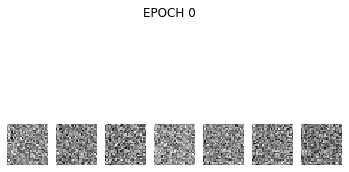

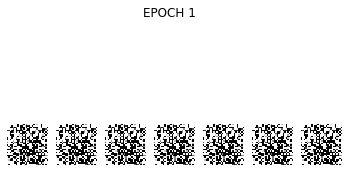

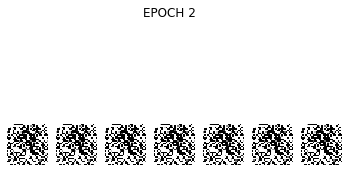

In [11]:
import time
start = time.time()
N_EPOCHS = 50

# Log info with no training
print("Training = "+str(0)+" % Complete:")
sample = torch.Tensor(fashion_GAN.generate(7)).reshape(7,28,28)
show_images(sample,7,"EPOCH "+str(0))

for e in range(1,N_EPOCHS+1):
    for i, (images,labels) in enumerate(data_loader):
        images = images.reshape(images.size(0),28*28) # Flattens image to a vector
        g_error,d_error,avg_real_pred,avg_fake_pred = fashion_GAN.batch_train(images,0.005*0.002,0.002) #d lr then g lr

        # EPOCH Progress info
        epoch_progress = round(i*100/len(data_loader))
        if (epoch_progress) % 20 == 0:
            print("\tEPOCH "+str(epoch_progress)+"% Complete:")
            print("\t\t Generator Loss =     "+str(g_error))
            print("\t\t Discriminator Loss = "+str(d_error))
            
            print("\t\t\t avg prediction on real data = "+str(avg_real_pred)) # Prints avg predictions on real data (discrim wants this to be 1, we want 0.5)
            print("\t\t\t avg prediction on fake data = "+str(avg_fake_pred)) # Prints avg predictions on fake data (discrim wants this to be 0, we want 0.5)
    
    # Overall Progress Info
    print("Training = "+str(100*e/N_EPOCHS)+" % Complete:")
    sample = torch.Tensor(fashion_GAN.generate(7)).reshape(7,28,28)
    show_images(sample,7,"EPOCH "+str(e))

end = time.time()
print('Total Training Time = ',(end - start)/60 + " mins")

In [ ]:
# Prints 25 sample images produced by the GAN
samples = torch.Tensor(fashion_GAN.generate(25)).reshape(25,28,28)

fig, ax = plt.subplots(5,5) # Makes an array of subplot objects 
fig.suptitle('25 Generated Samples')

for i, j in np.ndindex((5,5)):
    ax[i][j].imshow(samples[5*i+j].squeeze(), cmap='gray_r'); # Investigate the cmap
    ax[i][j].axis('off')